In [17]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

trainDataset = torchvision.datasets.FashionMNIST("fashionDataset", train=True, download=True, transform=transforms.ToTensor())
testDataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


x,y = trainDataset[0]
print(y)

cuda
9


In [18]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 3, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(3, 9, kernel_size=5, padding=2)
        self.conv3 = torch.nn.Conv2d(9, 20, kernel_size=5, padding=2)
        self.conv4 = torch.nn.Conv2d(20, 25, kernel_size=5, padding=2)
        self.fc1 = torch.nn.Linear(225, 100)
        self.fc2 = torch.nn.Linear(100, 10)
        self.drop = torch.nn.Dropout(0.20)
        self.pool = torch.nn.MaxPool2d(2, 2) #Halfs image

        self.conv = torch.nn.Sequential(
            self.pool,
            torch.nn.ReLU()
        )
    
    def forward(self, x):

        x = self.conv(self.conv1(x))
        x = self.conv(self.conv2(x))
        x = self.conv(self.conv3(x))
        x = torch.nn.functional.relu(self.conv4(x))
        x = x.reshape((-1, 225))
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    


class RisNN(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.resBlocks = torch.nn.Sequential(
            resBlock(1,1),
            resBlock(1,1),
            resBlock(1,1),
            resBlock(1,1)
        )
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(784, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10)
        )
        self.relu = torch.nn.ReLU()
    
    def forward(self,x): 
        x = self.resBlocks(x)
        x = x.reshape((-1, 784))
        x = self.fc1(x)
        return x


    
class resBlock(torch.nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(inChannels, outChannels, kernel_size=5, padding=2)
        self.conv2 = torch.nn.Conv2d(outChannels, outChannels, kernel_size=5, padding=2)
        self.bn = torch.nn.BatchNorm2d(outChannels, track_running_stats=False)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.bn(x)
        y = self.conv1(x)
        y = self.relu(y)
        y = self.conv2(y)
        y = self.bn(y)
        y = self.relu(y)
        x = x + y
        return x
    
test = torch.randn(size=(100, 1, 28, 28),device=device)
model = RisNN()
model.to(device)






RisNN(
  (resBlocks): Sequential(
    (0): resBlock(
      (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
    (1): resBlock(
      (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
    (2): resBlock(
      (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
    (3): resBlock(
      (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 

In [19]:
epochs =30
batchSize = 600
dataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True, num_workers=4)


loss = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)




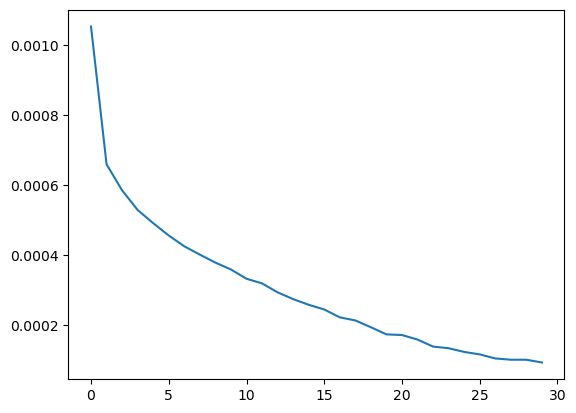

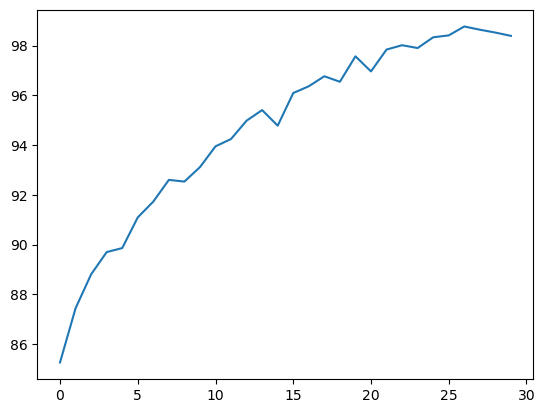

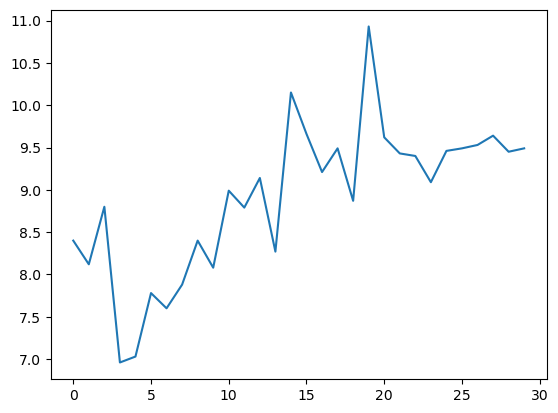

In [20]:
from IPython.display import clear_output

history = []
accuracy = []
validationAcc = []
for i in range(epochs):
    model.train()
    totalCost = 0
  
    for xBatch, yBatch in dataloader:
        optimiser.zero_grad()
        xBatch = xBatch.to(device)
        yBatch = yBatch.to(device)
        
        y_this = model(xBatch)
        cost = loss(y_this, yBatch)
        cost.backward()
        totalCost += cost.item()

        optimiser.step()
    ##Plot acc
    model.eval()
    ySet = trainDataset.targets.to(device)
    xSet = trainDataset.data.reshape(-1, 1, 28, 28)
    xSet = xSet.to(device).to(torch.float)
    modelOutput = model(xSet)

    indexOut = torch.argmax(modelOutput, dim=1)
    matches = indexOut == ySet
    accuracy.append(matches.sum().item()*100/len(ySet))

    plt.figure(figsize=(6,3))
    plt.plot(accuracy)
    plt.show()
    print(i)
    clear_output(wait=True)

    history.append(totalCost/len(trainDataset))

    ##
    ##Test validation set
    model.eval()
    ySet = testDataset.targets.to(device)
    xSet = testDataset.data.reshape(-1, 1, 28, 28)
    xSet = xSet.to(device).to(torch.float)
    modelOutput = model(xSet)
    indexOut = torch.argmax(modelOutput, dim=1)
    matches = indexOut == ySet
    validationAcc.append(matches.sum().item()*100/len(ySet))
plt.plot(history)
plt.show()
plt.plot(accuracy)
plt.show()
plt.plot(validationAcc)
plt.show()




In [21]:
torch.save(model.state_dict(), "resModelParams.pt")

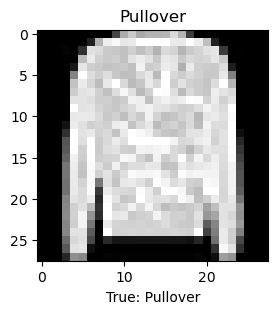

In [35]:
model.eval()
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
testImage, expectedOutput = trainDataset[27]
testImage = testImage.reshape(1,28,28)
modelOutput = model(testImage.to(device).reshape(-1, 1, 28, 28))
index = torch.argmax(modelOutput[0], dim=0).item()

plt.figure(figsize=[6,3])
plt.title( labels[index])
plt.xlabel("True: "+labels[expectedOutput])
plt.imshow(testImage[0], cmap="gray")

In [14]:
##Test Entire ds for accuracy
model.eval()
ySet = trainDataset.targets.to(device)
xSet = trainDataset.data.reshape(-1, 1, 28, 28)
xSet = xSet.to(device).to(torch.float)
modelOutput = model(xSet)

indexOut = torch.argmax(modelOutput, dim=1)
matches = indexOut == ySet
print(matches.sum().item()*100/len(ySet))


100.0


In [15]:
##Test validation set
model.eval()
testDataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
ySet = testDataset.targets.to(device)
xSet = testDataset.data.reshape(-1, 1, 28, 28)
xSet = xSet.to(device).to(torch.float)
modelOutput = model(xSet)
indexOut = torch.argmax(modelOutput, dim=1)
matches = indexOut == ySet
print(matches.sum().item()*100/len(ySet))

10.29


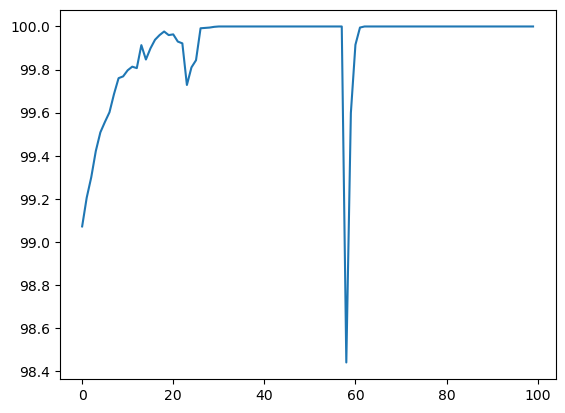

In [16]:
plt.plot(accuracy)
plt.show()

In [38]:
model.load_state_dict(torch.load("resModelParams.pt", map_location=device))

#get number of parameters in model
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

RuntimeError: Error(s) in loading state_dict for RisNN:
	Missing key(s) in state_dict: "resBlocks.0.conv1.weight", "resBlocks.0.conv1.bias", "resBlocks.0.conv2.weight", "resBlocks.0.conv2.bias", "resBlocks.0.bn.weight", "resBlocks.0.bn.bias", "resBlocks.1.conv1.weight", "resBlocks.1.conv1.bias", "resBlocks.1.conv2.weight", "resBlocks.1.conv2.bias", "resBlocks.1.bn.weight", "resBlocks.1.bn.bias", "resBlocks.2.conv1.weight", "resBlocks.2.conv1.bias", "resBlocks.2.conv2.weight", "resBlocks.2.conv2.bias", "resBlocks.2.bn.weight", "resBlocks.2.bn.bias", "resBlocks.3.conv1.weight", "resBlocks.3.conv1.bias", "resBlocks.3.conv2.weight", "resBlocks.3.conv2.bias", "resBlocks.3.bn.weight", "resBlocks.3.bn.bias". 
	Unexpected key(s) in state_dict: "c1.0.weight", "c1.0.bias", "bn.weight", "bn.bias". 